In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = "maize_dataset"

In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [4]:
os.listdir(data_dir)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
for image_class in os.listdir(data_dir):
    print(image_class)

Blight
Common_Rust
Gray_Leaf_Spot
Healthy


In [6]:
one_img_path = cv.imread(os.path.join(data_dir,'Blight', "Corn_Blight (1).jpg"))

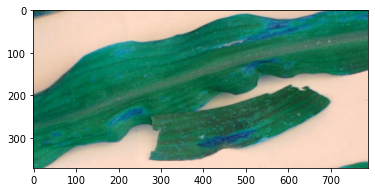

In [7]:
plt.imshow(one_img_path)

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory("maize_dataset")

Found 4187 files belonging to 4 classes.


In [9]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 3 1 1 0 1 1 0 1 0 2 3 1 0 1 0 0 1 1 3 0 3 2 3 2 2 2 0 2 1 3 2]


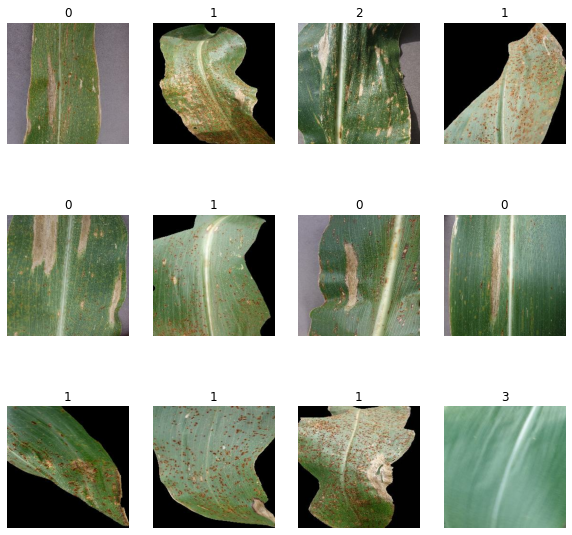

In [11]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
        plt.title(labels_batch[i].numpy())
        plt.axis("off")

In [12]:
len(dataset)

131

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

104

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
104/104 [==============================] - 1619s 15s/step - loss: 0.8520 - accuracy: 0.6199 - val_loss: 0.4318 - val_accuracy: 0.8149
Epoch 2/5
104/104 [==============================] - 1791s 17s/step - loss: 0.4477 - accuracy: 0.8152 - val_loss: 0.3978 - val_accuracy: 0.8173
Epoch 3/5
104/104 [==============================] - 1783s 17s/step - loss: 0.4318 - accuracy: 0.8191 - val_loss: 0.3756 - val_accuracy: 0.8317
Epoch 4/5
104/104 [==============================] - 1771s 17s/step - loss: 0.3930 - accuracy: 0.8327 - val_loss: 0.3670 - val_accuracy: 0.8341
Epoch 5/5
104/104 [==============================] - 1786s 17s/step - loss: 0.3730 - accuracy: 0.8366 - val_loss: 0.3616 - val_accuracy: 0.8462


In [24]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 75s 4s/step - loss: 0.4351 - accuracy: 0.8326


In [25]:
scores

[0.4351458251476288, 0.8325892686843872]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 104}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['loss'][:5] 

[0.8520295023918152,
 0.4476518929004669,
 0.4317866861820221,
 0.39302513003349304,
 0.37303611636161804]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

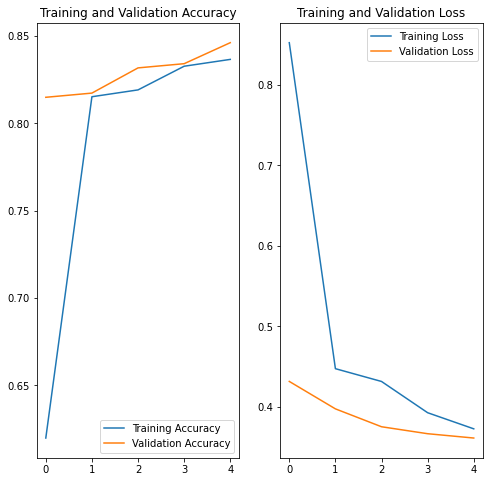

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blight
1/1 [==============================] - 3s 3s/step
predicted label: Blight


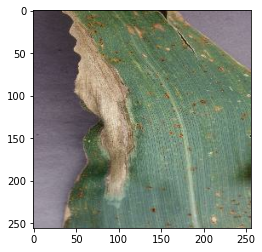

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 118ms/step


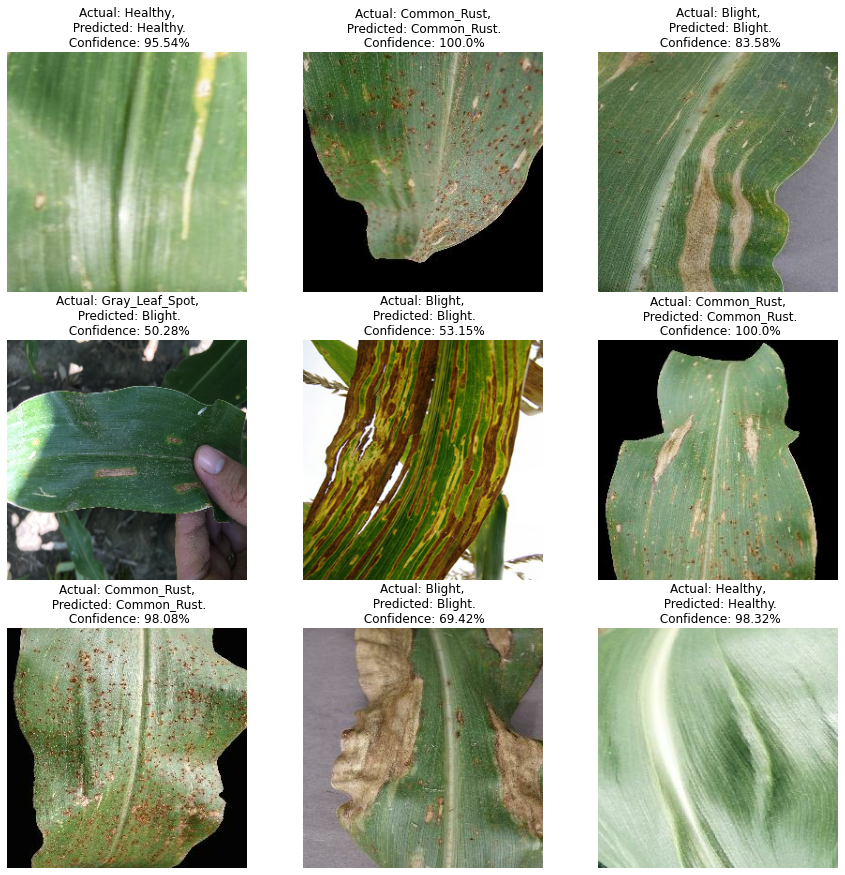

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [103]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [105]:
model.save("../maize.h5")

In [106]:
import cv2

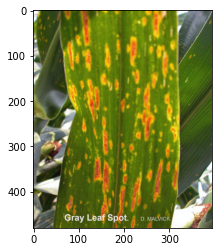

In [156]:
img = cv2.imread('grayleafspot2_600px.jpg')
# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

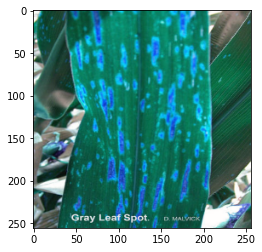

In [163]:
resize = tf.image.resize(img, (256,256))
# resize = tf.image.resize(img)

plt.imshow(resize.numpy().astype(int))
plt.show()

In [170]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [175]:
np.argmax(array([[8.9812957e-16, 1.0000000e+00, 2.7374273e-16, 4.5284643e-24]]))

NameError: name 'array' is not defined

In [164]:
from keras import models
from keras.models import load_model

In [165]:
reload_model = load_model(os.path.join('models', "maize.h5"))

In [167]:
reload_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 470ms/step


array([[8.9812957e-16, 1.0000000e+00, 2.7374273e-16, 4.5284643e-24]],
      dtype=float32)

In [137]:
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [145]:
# reload_model.predict("PLNTPTH-CER-02_Figure_1.jpg")
reload_model.predict(np.expand_dims("PLNTPTH-CER-02_Figure_1.jpg"/255, 0))

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [213]:
datasets = tf.keras.utils.image_dataset_from_directory("testing")

Found 1 files belonging to 1 classes.


first image to predict
actual label: Blight
1/1 [==============================] - 0s 140ms/step
predicted label: Gray_Leaf_Spot


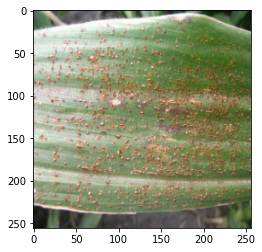

In [215]:
import numpy as np
for images_batch, labels_batch in datasets.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])